<a href="https://colab.research.google.com/github/hikaru122700/kaggle-private/blob/SMBC/085.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [106]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

# import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import matplotlib.pyplot as plt


import os
from catboost import CatBoostClassifier


In [107]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv(path+'train_all_df_084.csv', index_col=0)
print(len(train_df))
# train_df.drop("GHG_Direct_Emissions_14_in_metric_tons", axis=1, inplace=True)
# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv(path+'test_all_df_084.csv', index_col=0)
test_df["oof_predictions"] = test_df["test_preds"]

3537


In [108]:
diff = abs(np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_df['oof_predictions']))

# 2. 条件を満たす行のマスクを作成
mask = diff > 0.1
# 3. 除外する行の数をカウント
exclude_num = mask.sum()
# 4. 条件を満たさない行だけを保持
train_df = train_df[~mask].reset_index(drop=True)

# 6. 結果の表示
print(f"除外された行数: {exclude_num}")


除外された行数: 2882


In [109]:
train_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347","55,910"
1,NaN,NaN,80,NaN,"1,104,853","1,775,777","695,123",37,-82,NaN,NaN,NaN,NaN,NaN,NaN,8,1,"1,347,900","1,221,687"
2,NaN,NaN,3,NaN,NaN,"58,457","58,295",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,251","55,857"
3,NaN,NaN,221,"57,705","35,212","55,183","10,377",31,-92,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"39,810","43,381"
4,NaN,NaN,21,"287,865","870,154","4,134,515","243,133",45,-93,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"908,188","882,859"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,"23,685","21,105",87,"63,987","69,921","103,397","76,257",41,-112,"-11,550","8,910","-2,581",-0,1,-0,8,0,"79,066","84,368"
651,"38,311","36,565",21,"78,719","80,508","59,901","41,643",40,-110,"6,678","-6,395","-1,746",0,-0,-0,15,0,"59,573","60,240"
652,NaN,NaN,21,"1,572,744","279,974","4,826,455","2,193,342",30,-97,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"1,580,094","1,745,346"
653,NaN,NaN,21,"52,693","51,609","58,938","35,526",31,-88,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"43,854","40,675"


In [110]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1'],
      dtype='object')

In [111]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [112]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


In [113]:

# x=train_df["GHG_Direct_Emissions_12_in_metric_tons"]
# y=train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
# # 実測値と予測値を対数スケールでプロット
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=x, y=y, alpha=0.5)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('before')
# plt.ylabel('target')
# plt.title('Actual vs Predicted Values (Log-Log Scale)')
# plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
# plt.show()

In [114]:

# show_plot(train_df["GHG_Direct_Emissions_13_in_metric_tons"],
#           train_df["GHG_Direct_Emissions_14_in_metric_tons.1"],
#           "train_G13-train_G14")
# show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
#           np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
#           "train_log_G13-train_log_G14")
# show_plot(np.log(train_df["GHG_Direct_Emissions_12_in_metric_tons"]),
#           np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
#           "train_log_G12-train_log_G13")


In [115]:
train_all_df = pd.concat([train_df, test_df], axis=0)
train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"][len(train_df):] = test_df["test_preds"]
print(train_all_df.columns)
train_all_df.drop('test_preds', axis=1, inplace=True)
test_df.drop('oof_predictions', axis=1, inplace=True)
test_df.rename(columns={'test_preds': 'oof_predictions'}, inplace=True)

Index(['TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'test_preds'],
      dtype='object')


In [116]:
test_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions
0,NaN,NaN,4,"88,951","65,803","28,993","32,965",38,-98,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"45,894"
1,NaN,NaN,221,NaN,NaN,"311,926","268,668",32,-109,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"292,322"
2,"26,446","23,385",130,"84,908","6,213","34,733","39,045",41,-79,"3,800","-5,629","-3,061",0,-0,-0,8,0,"42,088"
3,"43,906","42,958",82,"49,005",52,"14,262","20,205",45,-93,"5,174","1,402",-948,0,0,-0,8,0,"30,093"
4,"40,203","39,437",181,"84,960","15,351","40,007","63,935",33,-117,"-5,413",306,-766,-0,0,-0,8,0,"48,571"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"545,778"
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"96,388"
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"138,421"
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,138"


In [117]:
train_all_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347","55,910"
1,NaN,NaN,80,NaN,"1,104,853","1,775,777","695,123",37,-82,NaN,NaN,NaN,NaN,NaN,NaN,8,1,"1,347,900","1,221,687"
2,NaN,NaN,3,NaN,NaN,"58,457","58,295",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,251","55,857"
3,NaN,NaN,221,"57,705","35,212","55,183","10,377",31,-92,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"39,810","43,381"
4,NaN,NaN,21,"287,865","870,154","4,134,515","243,133",45,-93,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"908,188","882,859"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"545,778","545,778"
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"96,388","96,388"
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"138,421","138,421"
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,138","262,138"


In [118]:
len(train_df), len(train_all_df), len(test_df)

(655, 3163, 2508)

In [119]:
# 1. RMSLEの計算（ベクトル化）
# 'test_preds' と 'oof_predictions' を明示的に指定
diff = np.log1p(train_all_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_all_df['oof_predictions'])
train_all_df['diff'] = diff
train_df = train_all_df[:len(train_df)]
test_df = train_all_df[len(train_df):]

In [120]:
train_all_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1,diff
0,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347","55,910",-0
1,NaN,NaN,80,NaN,"1,104,853","1,775,777","695,123",37,-82,NaN,NaN,NaN,NaN,NaN,NaN,8,1,"1,347,900","1,221,687",-0
2,NaN,NaN,3,NaN,NaN,"58,457","58,295",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,251","55,857",0
3,NaN,NaN,221,"57,705","35,212","55,183","10,377",31,-92,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"39,810","43,381",0
4,NaN,NaN,21,"287,865","870,154","4,134,515","243,133",45,-93,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"908,188","882,859",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"545,778","545,778",0
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"96,388","96,388",0
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"138,421","138,421",0
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,138","262,138",0


In [121]:
train_all_df["oof_predictions"].fillna(train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"], inplace=True)
train_all_df["diff"].fillna(0, inplace=True)

In [122]:
train_all_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)
train_df_GHG14 = train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
train_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [123]:
test_df["oof_predictions"] = test_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
test_df.drop('GHG_Direct_Emissions_14_in_metric_tons.1', axis=1, inplace=True)

In [124]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {'iterations': 254,
                                        'depth': 5,
                                        'learning_rate': 0.08377009991199288,
                                        'l2_leaf_reg': 1,
                                        'bagging_temperature': 0.7204457890870082,
                                        'min_data_in_leaf': 4,
                                        "random_state":13,
                                         "verbose":0}
        model2                       = CatBoostRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_valid)
            rmsle = np.sqrt(mean_squared_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_error(y_valid, preds_comb))
                # print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_error(y_valid, preds_all))
        # print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict(train_eval) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)
            train_eval_preds = models[best_combination].predict(train_eval)

        # 各組み合わせの選択回数をインクリメント
        # combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds/ kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = test_predictions
    final_train_predictions = train_eval_predictions

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")
    print()
    return oof_predictions, final_test_predictions, final_train_predictions

In [125]:
train_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347",-0
1,NaN,NaN,80,NaN,"1,104,853","1,775,777","695,123",37,-82,NaN,NaN,NaN,NaN,NaN,NaN,8,1,"1,347,900",-0
2,NaN,NaN,3,NaN,NaN,"58,457","58,295",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,251",0
3,NaN,NaN,221,"57,705","35,212","55,183","10,377",31,-92,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"39,810",0
4,NaN,NaN,21,"287,865","870,154","4,134,515","243,133",45,-93,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"908,188",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,"23,685","21,105",87,"63,987","69,921","103,397","76,257",41,-112,"-11,550","8,910","-2,581",-0,1,-0,8,0,"79,066",0
651,"38,311","36,565",21,"78,719","80,508","59,901","41,643",40,-110,"6,678","-6,395","-1,746",0,-0,-0,15,0,"59,573",0
652,NaN,NaN,21,"1,572,744","279,974","4,826,455","2,193,342",30,-97,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"1,580,094",0
653,NaN,NaN,21,"52,693","51,609","58,938","35,526",31,-88,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"43,854",-0


In [126]:
train = train_df.iloc[:, :-1].values
train_target = train_df.iloc[:, -1].values
train_all = train_all_df.iloc[:, :-1].values
train_all_target = train_all_df.iloc[:, -1].values
test = test_df.iloc[:, :-1].values

In [127]:
train_all_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347",-0
1,NaN,NaN,80,NaN,"1,104,853","1,775,777","695,123",37,-82,NaN,NaN,NaN,NaN,NaN,NaN,8,1,"1,347,900",-0
2,NaN,NaN,3,NaN,NaN,"58,457","58,295",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,251",0
3,NaN,NaN,221,"57,705","35,212","55,183","10,377",31,-92,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"39,810",0
4,NaN,NaN,21,"287,865","870,154","4,134,515","243,133",45,-93,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"908,188",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"545,778",0
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"96,388",0
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"138,421",0
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"262,138",0


In [128]:
train_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"59,347",-0
1,NaN,NaN,80,NaN,"1,104,853","1,775,777","695,123",37,-82,NaN,NaN,NaN,NaN,NaN,NaN,8,1,"1,347,900",-0
2,NaN,NaN,3,NaN,NaN,"58,457","58,295",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,251",0
3,NaN,NaN,221,"57,705","35,212","55,183","10,377",31,-92,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"39,810",0
4,NaN,NaN,21,"287,865","870,154","4,134,515","243,133",45,-93,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"908,188",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,"23,685","21,105",87,"63,987","69,921","103,397","76,257",41,-112,"-11,550","8,910","-2,581",-0,1,-0,8,0,"79,066",0
651,"38,311","36,565",21,"78,719","80,508","59,901","41,643",40,-110,"6,678","-6,395","-1,746",0,-0,-0,15,0,"59,573",0
652,NaN,NaN,21,"1,572,744","279,974","4,826,455","2,193,342",30,-97,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"1,580,094",0
653,NaN,NaN,21,"52,693","51,609","58,938","35,526",31,-88,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"43,854",-0


In [129]:
train_df_GHG14 = pd.Series(train_df_GHG14)
len(train_df_GHG14)

655

In [130]:
import time
epock = 20
for i in range(epock):
    st = time.time()
    train = train_df.iloc[:, :-1].values
    train_all = train_all_df.iloc[:, :-1].values
    train_all_target = train_all_df.iloc[:, -1].values
    oof_predictions,test_preds, train_preds  = get_models_trained(train_all, test, train_all_target, 15, train)
    train_all_df["oof_predictions"] = np.expm1(np.log1p(train_all_df["oof_predictions"])+oof_predictions)
    train_df["oof_predictions"] = np.expm1(np.log1p(train_df["oof_predictions"])+train_preds)
    test_df["oof_predictions"] = np.expm1(np.log1p(test_df["oof_predictions"])+test_preds)
    # train_all_df のインデックスをリセット
    train_all_df = train_all_df.reset_index(drop=True)

# train_df_GHG14 のインデックスをリセット
    train_df_GHG14 = train_df_GHG14.reset_index(drop=True)
    train_all_df['diff'] = np.log1p(train_df_GHG14) - np.log1p(train_all_df['oof_predictions'])
    # print(train_all_df.iloc[-1, -1])
    train_all_df.fillna(0, inplace=True)
    train_df['diff'] = np.log1p(train_df_GHG14) - np.log1p(train_df['oof_predictions'])
    print(f"{i}番目の学習が終わりました。\n")
    print(f"推定時間は{int(((epock-1-i)*(time.time()-st))/60)}\n")

Starting Fold 1
Fold 1 RMSLE for model1 = 0.02380276708671585
Fold 1 RMSLE for model2 = 0.024765023694809412
Fold 1 RMSLE for model3 = 0.02389979130735769
Fold 1 RMSLE for model4 = 0.024130614512361013
Fold 1 best combination: model1 with RMSLE = 0.02380276708671585
---------------

Starting Fold 2
Fold 2 RMSLE for model1 = 0.02791279275104344
Fold 2 RMSLE for model2 = 0.02907997728028176
Fold 2 RMSLE for model3 = 0.027967115150224212
Fold 2 RMSLE for model4 = 0.028889540229683763
Fold 2 best combination: ('model1', 'model3') with RMSLE = 0.02790715202100082
---------------

Starting Fold 3
Fold 3 RMSLE for model1 = 0.02427635542993447
Fold 3 RMSLE for model2 = 0.024956497007095246
Fold 3 RMSLE for model3 = 0.024239149517310144
Fold 3 RMSLE for model4 = 0.024584021174900026
Fold 3 best combination: ('model1', 'model3') with RMSLE = 0.024204291417196027
---------------

Starting Fold 4
Fold 4 RMSLE for model1 = 0.024897501800535224
Fold 4 RMSLE for model2 = 0.02547632741018925
Fold 4 RM

In [131]:
train_all_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,0,0,221,"55,508","72,387","58,225","76,377",38,-81,0,0,0,0,0,0,14,1,"58,746",-0
1,0,0,80,0,"1,104,853","1,775,777","695,123",37,-82,0,0,0,0,0,0,8,1,"1,353,619",-0
2,0,0,3,0,0,"58,457","58,295",0,0,0,0,0,0,0,0,9,1,"54,960",0
3,0,0,221,"57,705","35,212","55,183","10,377",31,-92,0,0,0,0,0,0,14,1,"39,598",0
4,0,0,21,"287,865","870,154","4,134,515","243,133",45,-93,0,0,0,0,0,0,15,1,"931,497",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158,0,0,240,"110,523","98,955","3,467,008","147,802",39,-76,0,0,0,0,0,0,1,1,"545,814",0
3159,0,0,4,0,0,0,0,31,-102,0,0,0,0,0,0,9,1,"95,532",0
3160,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"139,126",0
3161,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"268,067",0


In [132]:
train_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"58,965",-0
1,NaN,NaN,80,NaN,"1,104,853","1,775,777","695,123",37,-82,NaN,NaN,NaN,NaN,NaN,NaN,8,1,"1,332,976",-0
2,NaN,NaN,3,NaN,NaN,"58,457","58,295",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,209",0
3,NaN,NaN,221,"57,705","35,212","55,183","10,377",31,-92,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"39,765",0
4,NaN,NaN,21,"287,865","870,154","4,134,515","243,133",45,-93,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"913,222",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,"23,685","21,105",87,"63,987","69,921","103,397","76,257",41,-112,"-11,550","8,910","-2,581",-0,1,-0,8,0,"79,311",0
651,"38,311","36,565",21,"78,719","80,508","59,901","41,643",40,-110,"6,678","-6,395","-1,746",0,-0,-0,15,0,"59,584",0
652,NaN,NaN,21,"1,572,744","279,974","4,826,455","2,193,342",30,-97,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"1,595,868",0
653,NaN,NaN,21,"52,693","51,609","58,938","35,526",31,-88,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"43,526",-0


In [133]:
oof_predictions = pd.Series(oof_predictions, name='oof_predictions')


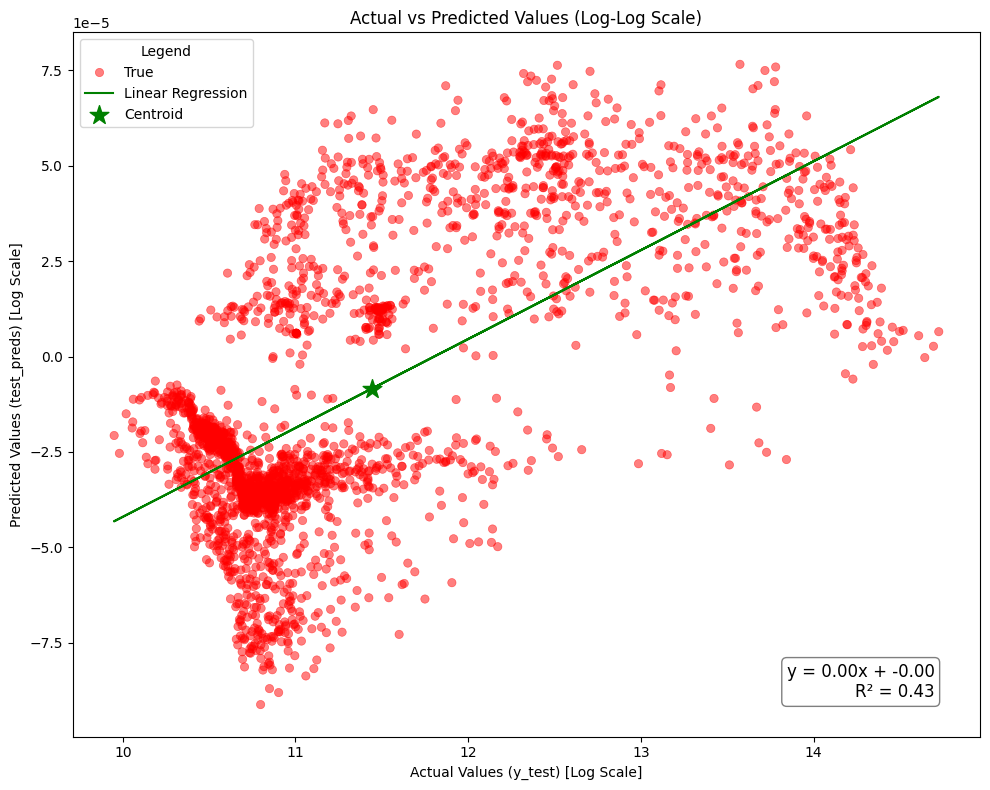

重心 (Centroid) の座標: (11.44, -0.00)


In [134]:
"""
最後の学習に対して、どのくらい変化したかを目視できる
"""
from scipy import stats
# 対数変換
log_target = np.log1p(test_df["oof_predictions"])
log_oof_predictions = test_preds

# 差の計算
diff = abs(log_target - log_oof_predictions)

# diffが0.7を超えるかどうかのマスク作成
diff_threshold = 0.7
mask = diff > diff_threshold

# プロットの作成
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=log_target,
    y=log_oof_predictions,
    hue=mask,
    palette={False: 'blue', True: 'red'},
    alpha=0.5,
    edgecolor=None
)

plt.xlabel('Actual Values (y_test) [Log Scale]')
plt.ylabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 線形回帰の計算
slope, intercept, r_value, p_value, std_err = stats.linregress(log_target, log_oof_predictions)
regression_line = slope * log_target + intercept

# 回帰線のプロット
plt.plot(log_target, regression_line, color='green', label='Linear Regression')

# 回帰式の作成
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = r_value**2
equation_r2 = f'R² = {r_squared:.2f}'

# 回帰式をグラフ内の右下に表示
plt.text(
    0.95, 0.05,  # グラフ内の相対位置 (x, y) 0-1
    f'{equation}\n{equation_r2}',
    transform=plt.gca().transAxes,
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

# 重心の計算
centroid_x = np.mean(log_target)
centroid_y = np.mean(log_oof_predictions)

# 重心をプロットに追加（plt.scatterを使用）
plt.scatter(
    centroid_x,
    centroid_y,
    color='green',
    marker='*',
    s=200,  # マーカーのサイズ
    label='Centroid'
)

# 凡例の設定
plt.legend(title='Legend')

# プロットの表示
plt.tight_layout()
plt.show()

# 重心の座標を表示
print(f"重心 (Centroid) の座標: ({centroid_x:.2f}, {centroid_y:.2f})")

In [135]:
train_df_GHG14

,GHG_Direct_Emissions_14_in_metric_tons.1
0,"55,910"
1,"1,221,687"
2,"55,857"
3,"43,381"
4,"882,859"
...,...
650,"84,368"
651,"60,240"
652,"1,745,346"
653,"40,675"


In [136]:
test_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,4,"88,951","65,803","28,993","32,965",38,-98,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"45,618",0
1,NaN,NaN,221,NaN,NaN,"311,926","268,668",32,-109,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"292,931",0
2,"26,446","23,385",130,"84,908","6,213","34,733","39,045",41,-79,"3,800","-5,629","-3,061",0,-0,-0,8,0,"41,896",0
3,"43,906","42,958",82,"49,005",52,"14,262","20,205",45,-93,"5,174","1,402",-948,0,0,-0,8,0,"30,148",0
4,"40,203","39,437",181,"84,960","15,351","40,007","63,935",33,-117,"-5,413",306,-766,-0,0,-0,8,0,"48,485",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,240,"110,523","98,955","3,467,008","147,802",39,-76,NaN,NaN,NaN,NaN,NaN,NaN,1,1,"545,981",0
2504,NaN,NaN,4,NaN,NaN,NaN,NaN,31,-102,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"96,332",0
2505,"25,069","24,560",132,"166,520","469,733","82,559","85,775",41,-96,636,"1,477",-509,0,0,-0,8,0,"138,974",0
2506,"93,119","130,327",98,"71,774","936,032","336,961","156,640",39,-93,"16,356","-47,698","37,208",0,-0,0,8,0,"265,311",0


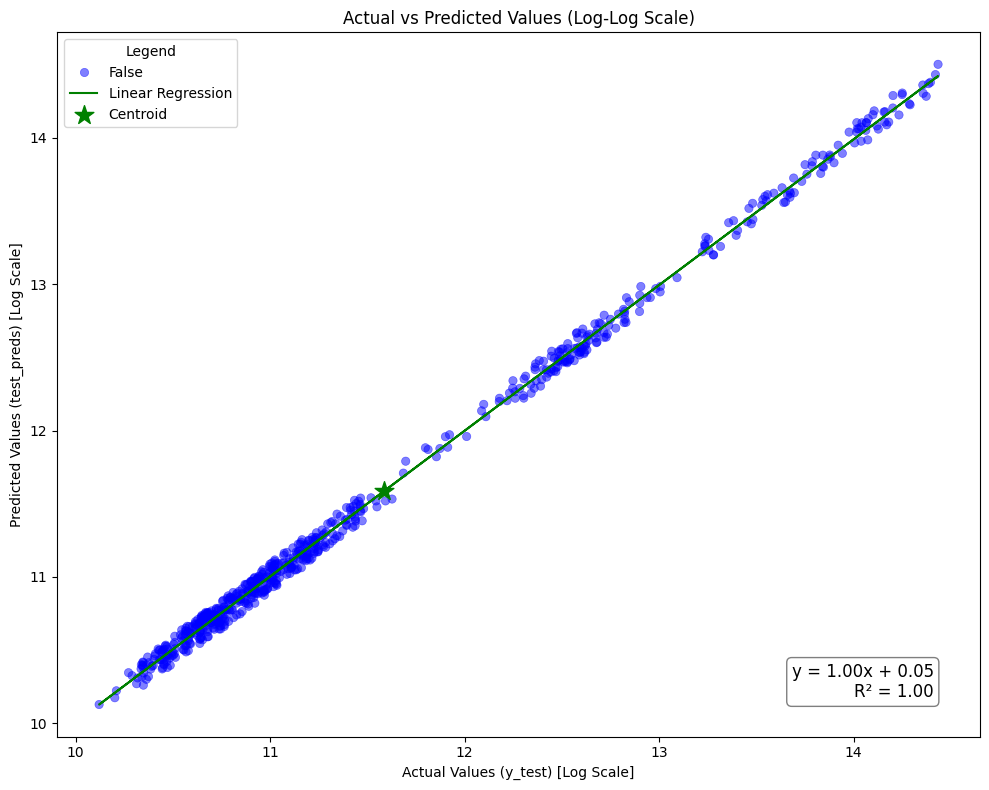

重心 (Centroid) の座標: (11.58, 11.59)


In [137]:

# 対数変換
log_target = np.log1p(train_df_GHG14)
log_oof_predictions = np.log1p(train_df["oof_predictions"])

# 差の計算
diff = abs(log_target - log_oof_predictions)

# diffが0.7を超えるかどうかのマスク作成
diff_threshold = 0.7
mask = diff > diff_threshold

# プロットの作成
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=log_target,
    y=log_oof_predictions,
    hue=mask,
    palette={False: 'blue', True: 'red'},
    alpha=0.5,
    edgecolor=None
)

plt.xlabel('Actual Values (y_test) [Log Scale]')
plt.ylabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 線形回帰の計算
slope, intercept, r_value, p_value, std_err = stats.linregress(log_target, log_oof_predictions)
regression_line = slope * log_target + intercept

# 回帰線のプロット
plt.plot(log_target, regression_line, color='green', label='Linear Regression')

# 回帰式の作成
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = r_value**2
equation_r2 = f'R² = {r_squared:.2f}'

# 回帰式をグラフ内の右下に表示
plt.text(
    0.95, 0.05,  # グラフ内の相対位置 (x, y) 0-1
    f'{equation}\n{equation_r2}',
    transform=plt.gca().transAxes,
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

# 重心の計算
centroid_x = np.mean(log_target)
centroid_y = np.mean(log_oof_predictions)

# 重心をプロットに追加（plt.scatterを使用）
plt.scatter(
    centroid_x,
    centroid_y,
    color='green',
    marker='*',
    s=200,  # マーカーのサイズ
    label='Centroid'
)

# 凡例の設定
plt.legend(title='Legend')

# プロットの表示
plt.tight_layout()
plt.show()

# 重心の座標を表示
print(f"重心 (Centroid) の座標: ({centroid_x:.2f}, {centroid_y:.2f})")

In [138]:
print(np.expm1(10.2))
print(np.log1p(26902.18607429754))
np.expm1(np.log1p(26902.18607429754)*100/102)

26902.18607429754
10.2


22025.465794806678

In [139]:
submit = pd.read_csv(path+'sample_submission.csv',  header = None)
submit

,0,1
0,4655,"249,574"
1,4656,"249,574"
2,4657,"249,574"
3,4658,"249,574"
4,4659,"249,574"
...,...,...
2503,7158,"249,574"
2504,7159,"249,574"
2505,7160,"249,574"
2506,7161,"249,574"


各ビンの y のジオメトリック平均: 206273.18802127865


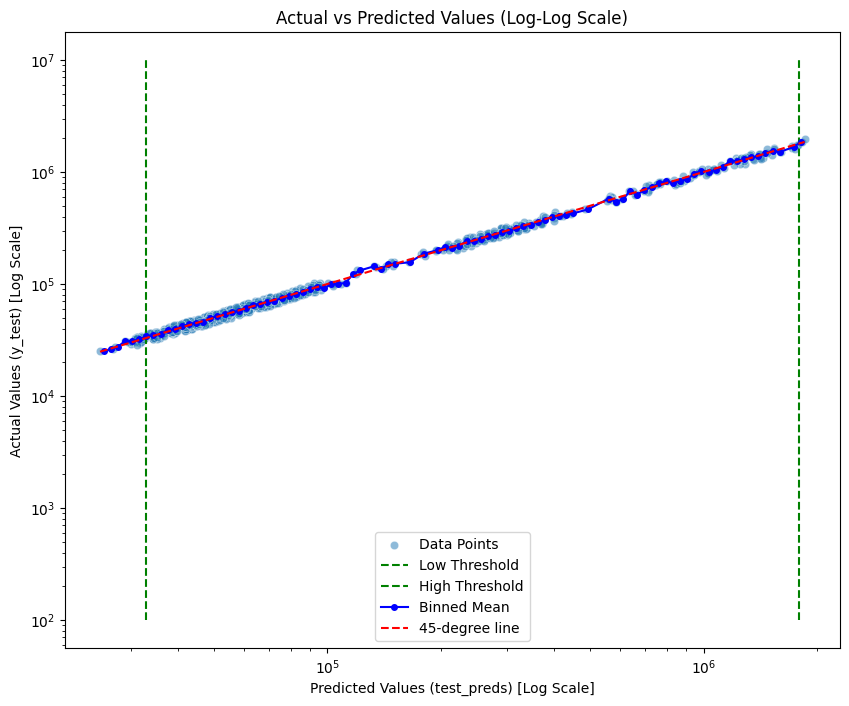

In [140]:

def calculate_binned_average(x, y, num_bins=50):
    """
    x を num_bins 個のビンに分け、それぞれのビン内の y の平均を計算します。

    Parameters:
    - x: 予測値の配列
    - y: 実測値の配列
    - num_bins: ビンの数

    Returns:
    - bins: ビンの境界
    - bin_centers: 各ビンの中心値
    - y_means: 各ビン内の y の平均値
    """
    # 対数スケールのビンを作成
    log_min = np.log10(x.min())
    log_max = np.log10(x.max())
    bins = np.logspace(log_min, log_max, num=num_bins)

    # ビンのインデックスを取得
    bin_indices = np.digitize(x, bins)

    # 各ビン内の y の平均を計算
    y_means = []
    bin_centers = []
    for i in range(1, len(bins)):
        mask = bin_indices == i
        if np.any(mask):
            y_mean = y[mask].mean()
            y_means.append(y_mean)
            bin_center = (bins[i-1] + bins[i]) / 2
            bin_centers.append(bin_center)

    return bins, np.array(bin_centers), np.array(y_means)


x = train_df_GHG14
y = train_df["oof_predictions"]
# ビンに分けて平均を計算
num_bins = 100
bins, bin_centers, y_means = calculate_binned_average(x, y, num_bins=num_bins)

# ジオメトリック平均の計算（ビンごとの y のジオメトリック平均）
geometric_mean_y_per_bin = np.exp(np.mean(np.log(y_means)))
print(f"各ビンの y のジオメトリック平均: {geometric_mean_y_per_bin}")

# プロットの作成
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x, y=y, alpha=0.5, label='Data Points')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Actual Values (y_test) [Log Scale]')
plt.xlabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')


# 基準点の垂直線のプロット
plt.plot([np.expm1(10.4), np.expm1(10.4)], [10**2, 10**7], 'g--', label='Low Threshold')
plt.plot([np.expm1(14.4), np.expm1(14.4)], [10**2, 10**7], 'g--', label='High Threshold')

# ビンごとの平均値の線を追加
plt.plot(bin_centers, y_means, color='b', linestyle='-', marker='o', markersize=4, label='Binned Mean')
# 45度線のプロット
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='45-degree line')

# 凡例の追加
plt.legend()

# プロットの表示
plt.show()

In [141]:
print(np.expm1(np.log1p(10)))

10.000000000000002


In [142]:
def after_act(preds):
    r = preds.copy()
    r_min = r.min()
    max_w = 10.4-np.log1p(r_min)
    for i in range(len(r)):
        if r[i] < np.expm1(10.4):
            # print(r[i]-np.expm1(np.log1p(r[i])-0.5*(10.4-np.log1p(r[i]))/max_w))
            r[i] = np.expm1(np.log1p(r[i])-0.5*(10.4-np.log1p(r[i]))/max_w)
    return r

after_test_preds = after_act(test_df["oof_predictions"])
after_train_preds = after_act(train_df["oof_predictions"])

各ビンの y のジオメトリック平均: 194014.1302993522


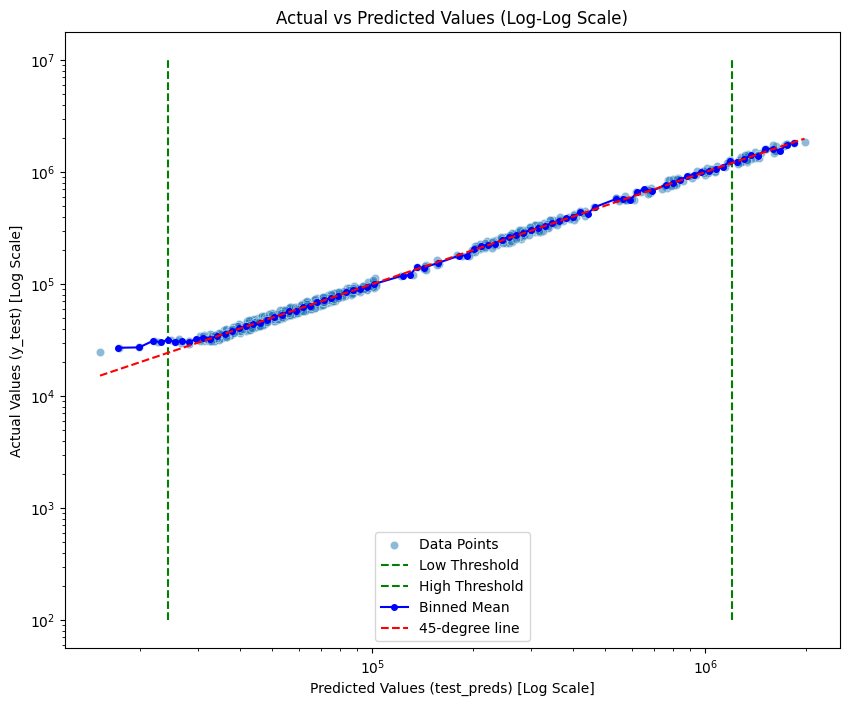

In [143]:
x = after_train_preds
y = train_df_GHG14

# ビンに分けて平均を計算
num_bins = 100
bins, bin_centers, y_means = calculate_binned_average(x, y, num_bins=num_bins)

# ジオメトリック平均の計算（ビンごとの y のジオメトリック平均）
geometric_mean_y_per_bin = np.exp(np.mean(np.log(y_means)))
print(f"各ビンの y のジオメトリック平均: {geometric_mean_y_per_bin}")

# プロットの作成
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x, y=y, alpha=0.5, label='Data Points')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Actual Values (y_test) [Log Scale]')
plt.xlabel('Predicted Values (test_preds) [Log Scale]')
plt.title('Actual vs Predicted Values (Log-Log Scale)')

# 45度線のプロット
# plt.plot([train_target.min(), train_target.max()], [train_target.min(), train_target.max()], 'r--', label='45-degree line')

# 基準点の垂直線のプロット
plt.plot([np.expm1(10.1), np.expm1(10.1)], [10**2, 10**7], 'g--', label='Low Threshold')
plt.plot([np.expm1(14.0), np.expm1(14.0)], [10**2, 10**7], 'g--', label='High Threshold')

# ビンごとの平均値の線を追加
plt.plot(bin_centers, y_means, color='b', linestyle='-', marker='o', markersize=4, label='Binned Mean')
# 45度線のプロット
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='45-degree line')

# 凡例の追加
plt.legend()

# プロットの表示
plt.show()

In [144]:
submit [ 1 ]  =  after_test_preds
submit.to_csv('SMBC_085.csv', index = False)
submit

,0,1
0,4655,"45,618"
1,4656,"292,931"
2,4657,"41,896"
3,4658,"27,398"
4,4659,"48,485"
...,...,...
2503,7158,"545,981"
2504,7159,"96,332"
2505,7160,"138,974"
2506,7161,"265,311"


In [145]:
np.expm1(14)

1202603.2841647768

In [146]:
pd.set_option('display.float_format', '{:,.0f}'.format)
threshold_input = 14
threshold = np.expm1(threshold_input)/1.05  # ≈ 1.718

# フィルタリング条件を定義
condition = (submit.iloc[:, 1] > threshold) & (submit.iloc[:, 0] > 1)

# 条件に合致する行を抽出
filtered_submit = submit[condition]
filtered_submit

,0,1
16,4671,"1,166,098"
110,4765,"1,358,413"
114,4769,"1,265,199"
148,4803,"1,738,743"
178,4833,"1,490,547"
...,...,...
2417,7072,"1,230,312"
2423,7078,"1,213,499"
2466,7121,"1,595,578"
2490,7145,"1,416,063"


In [147]:

# # show_plot(np.exp(oof_predictions), np.exp(target))
# show_plot(oof_predictions, target, "oof_predictions, target")
# show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
#           "train_df[GHG_Direct_Emissions_13_in_metric_tons], np.log(train_df[GHG_Direct_Emissions_14_in_metric_tons.1])")
# show_plot(np.log(test_df["GHG_Direct_Emissions_13_in_metric_tons"]), np.log(after_test_preds),
#           "test_df[GHG_Direct_Emissions_13_in_metric_tons], test_preds")
# show_plot(np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]), np.log(after_test_preds),
#           "train_df[GHG_Direct_Emissions_14_in_metric_tons], test_preds")
# show_plot(train_df.iloc[:, -1], after_train_preds, "train_df.iloc[:, -1], train_preds")

In [148]:
# show_plot(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"], test_preds, "test_df[GHG_Direct_Emissions_13_in_metric_tons], test_preds")

In [149]:
import time
print(time.ctime())

Sun Dec  1 12:40:35 2024


In [150]:
train_df

,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"58,965",-0
1,NaN,NaN,80,NaN,"1,104,853","1,775,777","695,123",37,-82,NaN,NaN,NaN,NaN,NaN,NaN,8,1,"1,332,976",-0
2,NaN,NaN,3,NaN,NaN,"58,457","58,295",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,209",0
3,NaN,NaN,221,"57,705","35,212","55,183","10,377",31,-92,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"39,765",0
4,NaN,NaN,21,"287,865","870,154","4,134,515","243,133",45,-93,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"913,222",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,"23,685","21,105",87,"63,987","69,921","103,397","76,257",41,-112,"-11,550","8,910","-2,581",-0,1,-0,8,0,"79,311",0
651,"38,311","36,565",21,"78,719","80,508","59,901","41,643",40,-110,"6,678","-6,395","-1,746",0,-0,-0,15,0,"59,584",0
652,NaN,NaN,21,"1,572,744","279,974","4,826,455","2,193,342",30,-97,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"1,595,868",0
653,NaN,NaN,21,"52,693","51,609","58,938","35,526",31,-88,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"43,526",-0


In [151]:
def culc(x, y):
    return  np.sqrt(mean_squared_log_error(x, y))

culc(train_df_GHG14, train_df["oof_predictions"])

0.05386376037968473

In [152]:
train_df


,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,diff
0,NaN,NaN,221,"55,508","72,387","58,225","76,377",38,-81,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"58,965",-0
1,NaN,NaN,80,NaN,"1,104,853","1,775,777","695,123",37,-82,NaN,NaN,NaN,NaN,NaN,NaN,8,1,"1,332,976",-0
2,NaN,NaN,3,NaN,NaN,"58,457","58,295",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,"55,209",0
3,NaN,NaN,221,"57,705","35,212","55,183","10,377",31,-92,NaN,NaN,NaN,NaN,NaN,NaN,14,1,"39,765",0
4,NaN,NaN,21,"287,865","870,154","4,134,515","243,133",45,-93,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"913,222",-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,"23,685","21,105",87,"63,987","69,921","103,397","76,257",41,-112,"-11,550","8,910","-2,581",-0,1,-0,8,0,"79,311",0
651,"38,311","36,565",21,"78,719","80,508","59,901","41,643",40,-110,"6,678","-6,395","-1,746",0,-0,-0,15,0,"59,584",0
652,NaN,NaN,21,"1,572,744","279,974","4,826,455","2,193,342",30,-97,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"1,595,868",0
653,NaN,NaN,21,"52,693","51,609","58,938","35,526",31,-88,NaN,NaN,NaN,NaN,NaN,NaN,15,1,"43,526",-0
